In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

In [5]:
# Verify GPU availability and clear the TensorFlow session
print("GPUs available: ", len(tf.config.experimental.list_physical_devices("GPU")))
tf.keras.backend.clear_session()

GPUs available:  1


## **Loading Data and Initial EDA**

In [6]:
# Define the base directory
dataset_path = r'maize-leaf-dataset'

# our classes 
classes = os.listdir(dataset_path)
print("Classes found:", classes)

Classes found: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


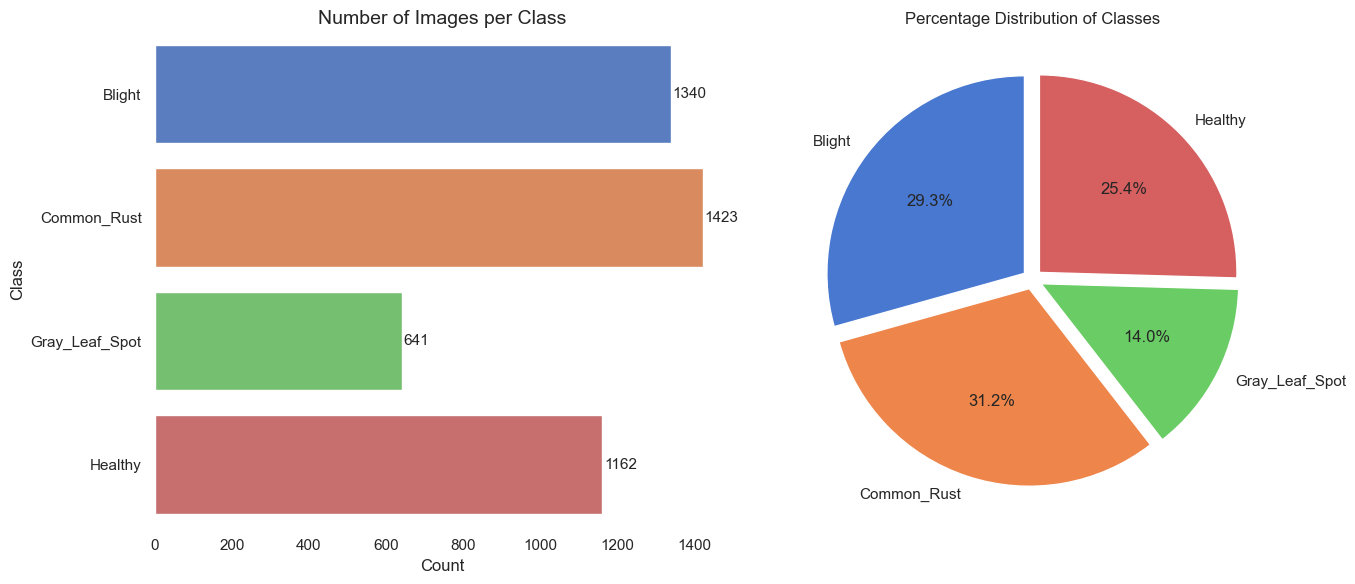

In [7]:
# Count number of images per class
class_counts = {}
for cls in classes:
    cls_dir = os.path.join(dataset_path, cls)
    num_images = len(os.listdir(cls_dir))
    class_counts[cls] = num_images

# Convert to DataFrame
df = pd.DataFrame({
    'Class': list(class_counts.keys()),
    'Count': list(class_counts.values())
})

# Set the style
sns.set(style='white')

# Create the figure
plt.figure(figsize=(14, 6))

# 1. Horizontal Bar Plot
plt.subplot(1, 2, 1)
ax = sns.barplot(y='Class', x='Count', data=df, hue='Class', palette='muted', dodge=False, legend=False)

# Remove grid and spines
ax.grid(False)
sns.despine(left=True, bottom=True)

# Annotate counts on bars
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{int(width)}', 
                (width + 5, p.get_y() + p.get_height() / 2), 
                ha='left', va='center', fontsize=11)

plt.title('Number of Images per Class', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Class')

# 2. Pie Chart
plt.subplot(1, 2, 2)
plt.pie(df['Count'], labels=df['Class'], autopct='%1.1f%%', 
        colors=sns.color_palette('muted'), startangle=90, explode=[0.05]*len(df))
plt.title('Percentage Distribution of Classes')

plt.tight_layout()
plt.show()

**Class Imbalance**<br>
There is a noticeable imbalance, especially for Gray Leaf Spot, which has significantly fewer samples than the others. This could cause the model to underperform on that class.

### Pixel intensities

In [8]:
from PIL import Image


# Function to load and process raw images
def get_pixel_stats(path, classes):
    class_pixel_data = {name: [] for name in classes}  
    
    # Iterate through each class
    for cls in classes:
        cls_dir = os.path.join(path, cls)
        if os.path.isdir(cls_dir):
            # Iterate through each image file in the class directory
            for image_name in os.listdir(cls_dir):
                image_path = os.path.join(cls_dir, image_name)
                
                # Open image
                try:
                    with Image.open(image_path) as img:
                        img = img.resize((256, 256))  # Resize image if necessary
                        img_array = np.array(img)  # Convert image to numpy array
                        class_pixel_data[cls].append(img_array.flatten())  # Flatten image and add to list
                except Exception as e:
                    print(f"Error loading {image_name}: {e}")
                    
    # Calculate mean and std dev for each class
    pixel_stats = {}
    for class_name, pixels in class_pixel_data.items():
        pixels = np.concatenate(pixels)  # Flatten all images into a single array per class
        mean = np.mean(pixels)  # Calculate the mean of pixel values
        std = np.std(pixels)    # Calculate the standard deviation of pixel values
        pixel_stats[class_name] = (mean, std)

    return pixel_stats

# Run the function and print results
pixel_stats = get_pixel_stats(dataset_path, classes)
for class_name, stats in pixel_stats.items():
    print(f"{class_name} - Mean: {stats[0]:.2f}, Std Dev: {stats[1]:.2f}")


Blight - Mean: 110.72, Std Dev: 45.35
Common_Rust - Mean: 89.68, Std Dev: 65.25
Gray_Leaf_Spot - Mean: 113.23, Std Dev: 47.80
Healthy - Mean: 137.68, Std Dev: 49.70


***Interpretation***
- **Blight**: The images in this class tend to be relatively dark with moderate variation. The disease may affect areas of the leaf in a way that results in less contrast in the image, making the images darker overall.

- **Common Rust**: The lower mean and higher standard deviation suggest that the images in this class are darker and more varied. This could indicate that rust affects the leaves in a highly variable manner, creating regions of high contrast (light and dark areas) in the images.

- **Gray Leaf Spot**: These images are generally brighter than Common Rust and have a moderate variation in brightness. This suggests that the leaf spots might cause localized bright areas while maintaining a more consistent brightness overall.

- **Healthy**: The higher mean and moderate standard deviation indicate that healthy leaves are generally bright and uniform, which makes sense as healthy plants usually reflect light evenly and don't have the variation in pixel values caused by diseases.

### Batching the Dataset

In [9]:
BATCH_SIZE = 32
IMAGE_SIZE = 220
CHANNELS=3

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4566 files belonging to 4 classes.


In [11]:
# gets the total number of batches in the dataset
len(dataset)

143

### Visualising Sample images

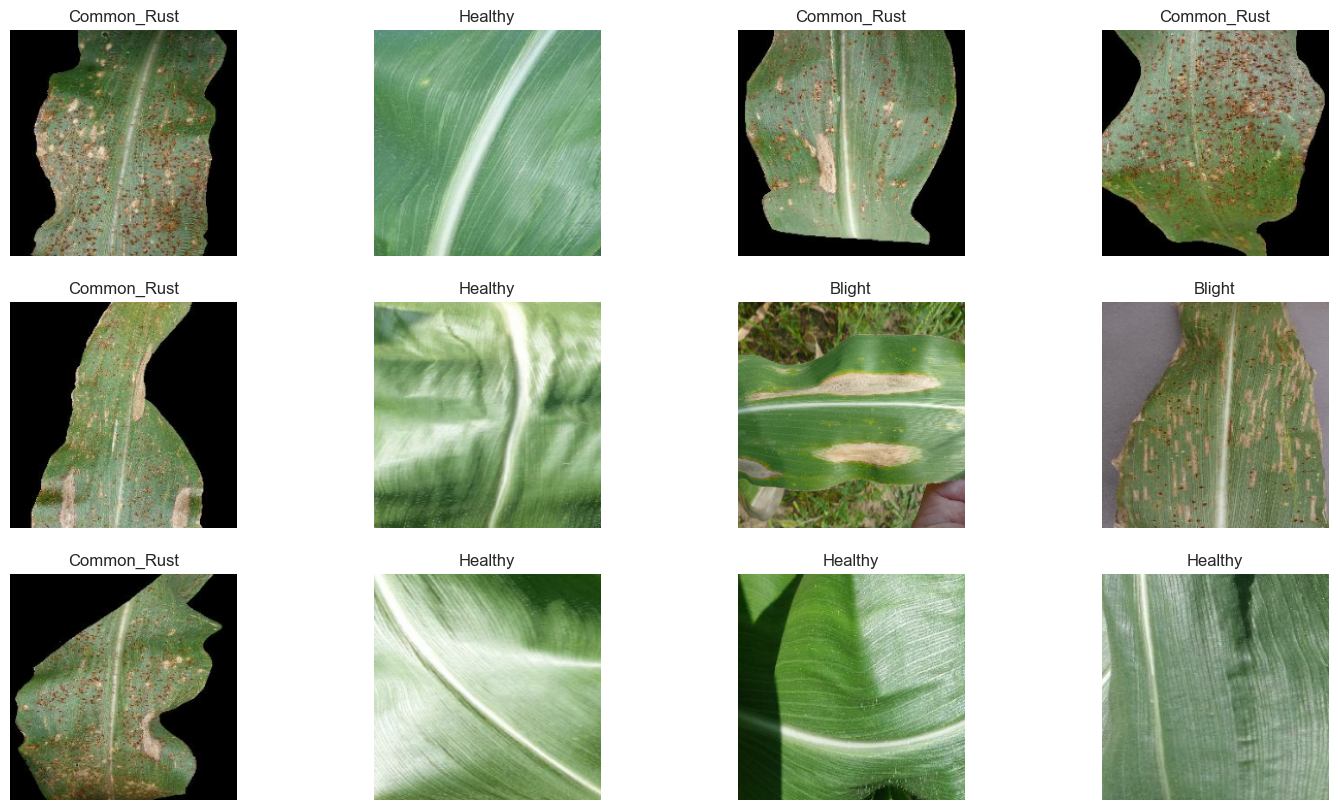

In [12]:
# Displaying a grid of images from a batch
plt.figure(figsize=(18, 10))  
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):  
        ax = plt.subplot(3, 4, i + 1)  
        plt.imshow(image_batch[i].numpy().astype("uint8"))  
        plt.title(classes[labels_batch[i]])  
        plt.axis("off")  
plt.show()

Visual Assesment:
1. **Common Rust**
Appears as: Small, rusty-red or brown spots (like cinnamon powder).


2. **Blight**
Appears as: Big, dark brown or black patches, like burnt leaves.


3. **Gray Leaf Spot**
Appears as: Rectangular gray or tan spots with dark edges.


4. **Healthy**
Appears as: Clean, green leaves with no spots or discoloration.

### Color Channel Analysis

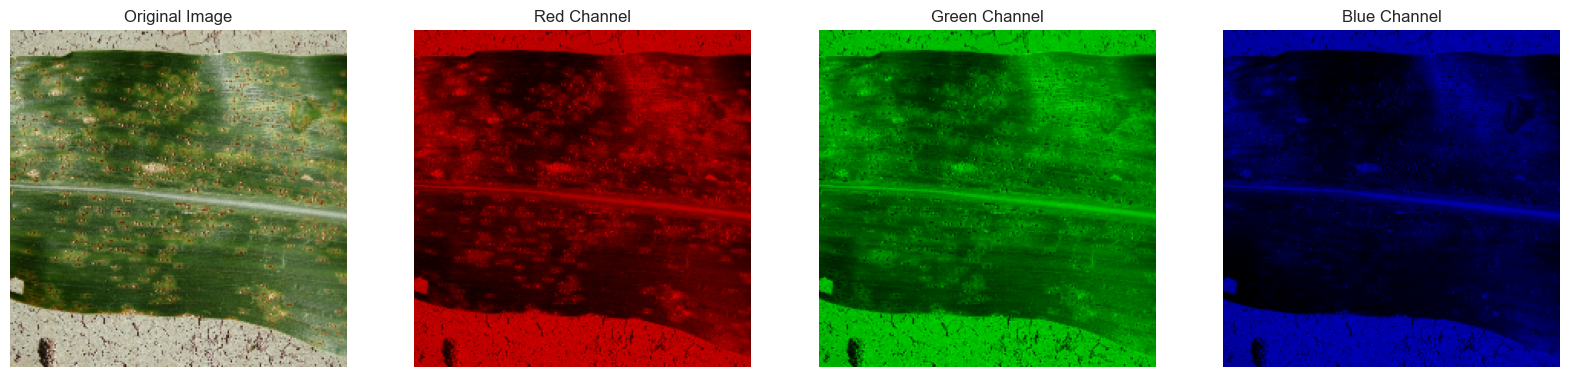

In [13]:
# Take one batch and one image from the dataset
for image_batch, label_batch in dataset.take(1):
    image = image_batch[0].numpy().astype("uint8")  
    break  

# Split the image into color channels
red_channel = image.copy()
green_channel = image.copy()
blue_channel = image.copy()

# Zero out other channels
# Red channel means Green and Blue set to 0
red_channel[:, :, 1] = 0
red_channel[:, :, 2] = 0

# Green channel means Red and Blue set to 0
green_channel[:, :, 0] = 0
green_channel[:, :, 2] = 0

# Blue channel means Red and Green set to 0
blue_channel[:, :, 0] = 0
blue_channel[:, :, 1] = 0

# Plotting each color channel
plt.figure(figsize=(20, 5))  

# Display original image
ax = plt.subplot(1, 4, 1)  
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Display red channel
ax = plt.subplot(1, 4, 2)  
plt.imshow(red_channel)
plt.title("Red Channel")
plt.axis("off")

# Display green channel
ax = plt.subplot(1, 4, 3)  
plt.imshow(green_channel)
plt.title("Green Channel")
plt.axis("off")

# Display blue channel
ax = plt.subplot(1, 4, 4)  
plt.imshow(blue_channel)
plt.title("Blue Channel")
plt.axis("off")

plt.show()

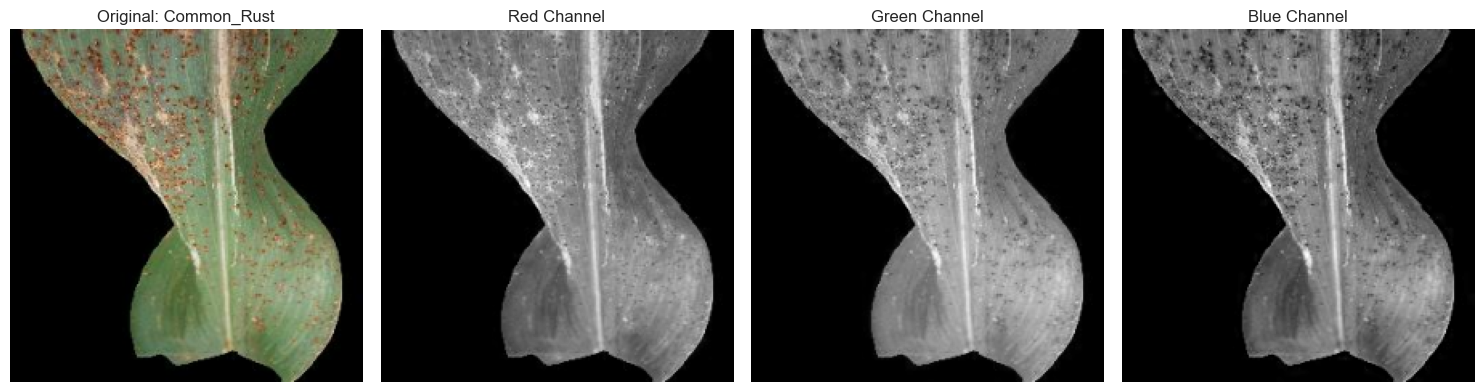

In [14]:
# Dataset and class_names are already defined
def display_image_channels(dataset, class_names):
    for image_batch, labels_batch in dataset.take(1):
        image = image_batch[0]

        # Split the image into its Red, Green, and Blue channels
        red_channel = image[:, :, 0]
        green_channel = image[:, :, 1]
        blue_channel = image[:, :, 2]

        plt.figure(figsize=(15, 5))

        # Display the original image
        plt.subplot(1, 4, 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(f"Original: {class_names[labels_batch[0]]}")
        plt.axis("off")

        # Display the Red channel
        plt.subplot(1, 4, 2)
        plt.imshow(red_channel, cmap="gray")
        plt.title("Red Channel")
        plt.axis("off")

        # Display the Green channel
        plt.subplot(1, 4, 3)
        plt.imshow(green_channel, cmap="gray")
        plt.title("Green Channel")
        plt.axis("off")

        # Display the Blue channel
        plt.subplot(1, 4, 4)
        plt.imshow(blue_channel, cmap="gray")
        plt.title("Blue Channel")
        plt.axis("off")

        # Show the plot
        plt.tight_layout()
        plt.show()

display_image_channels(dataset, classes)

Observational Insights from Color Channel Visualization
1. Original Image

- The original image retains its full RGB color information, making it visually representative of the actual dataset.
- Observing the complete image helps identify disease-specific patterns such as rust spots, discoloration, or healthy texture.
2. Red Channel

- The Red channel highlights reddish areas on the leaf, which are indicative of rust or other pigmentation-related issues.
- For diseases like Common_Rust, this channel is particularly relevant as the red spots are characteristic symptoms.
Other regions with low red intensity appear darker, indicating the dominance of other colors (green/blue).
3. Green Channel

- The Green channel emphasizes the chlorophyll-rich areas of the leaf, which are prominent in healthy leaves.
- Diseased leaves might show irregularities or inconsistencies in this channel due to discoloration or necrotic tissue.
This channel is critical for differentiating between Healthy and diseased classes like Blight or Gray_Leaf_Spot.
4. Blue Channel

- The Blue channel tends to highlight shadows and darker areas, providing contrast to the red and green channels.
- It may not be as visually informative as the red or green channels for identifying diseases but could help in feature extraction by providing complementary information.

## **Setting up a validation framework** ###

In [15]:
# split dataset into training, validation, and test sets.
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    #  Validate the splits
    assert (train_split + val_split + test_split) == 1, "Splits must sum to 1" 
    
    # Get the dataset size
    ds_size = ds.cardinality().numpy()
    print(f"Total dataset size: {ds_size}")
    
    # Shuffles the dataset randomly
    if shuffle:
        shuffle_size = max(shuffle_size, ds_size)
        ds = ds.shuffle(shuffle_size, seed=123)

    # Calculate partition sizes
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = ds_size - train_size - val_size  
    
     # Split the dataset
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

# Split the dataset
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print(f"Training batches: {len(train_ds)}")   # Output the number of training batches
print(f"Validation batches: {len(val_ds)}")  
print(f"Testing batches: {len(test_ds)}")    

Total dataset size: 143
Training batches: 114
Validation batches: 14
Testing batches: 15


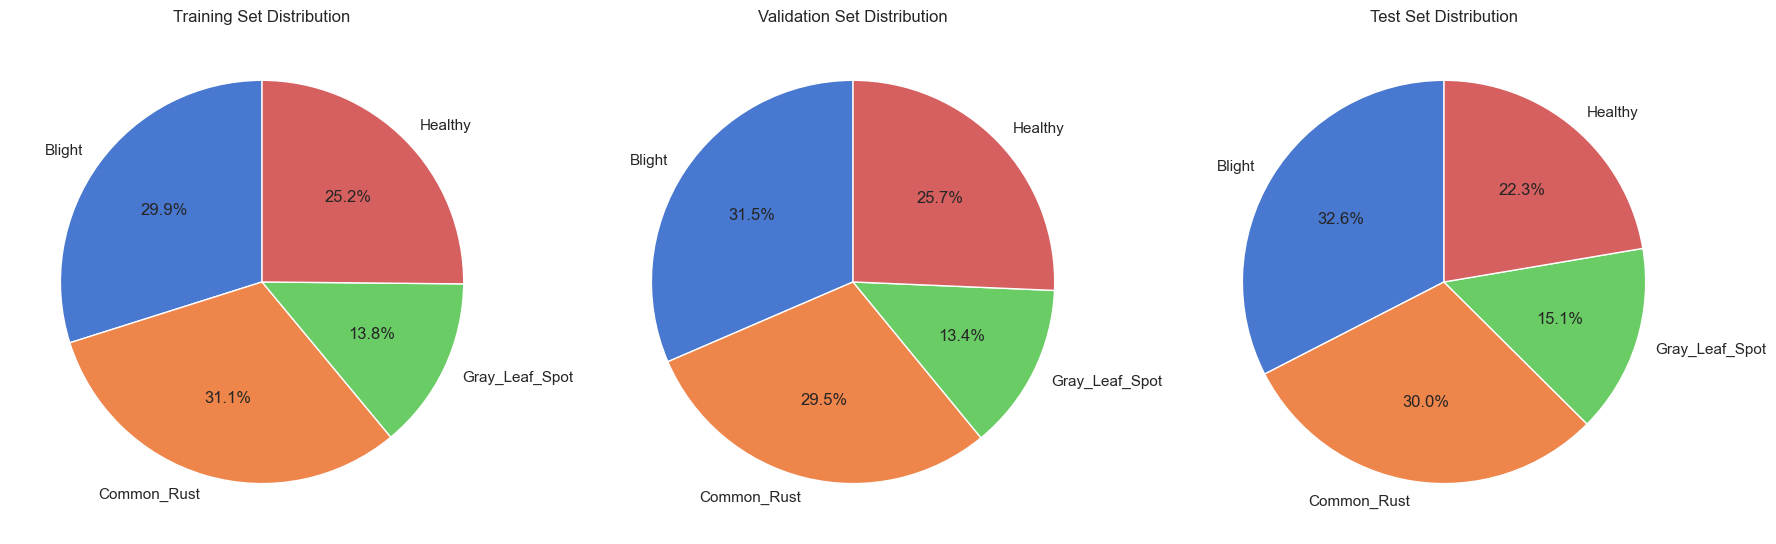

In [16]:
def count_classes(dataset, class_names):
    class_counts = {name: 0 for name in class_names}
    for _, labels in dataset.as_numpy_iterator():
        for label in labels:
            class_counts[class_names[label]] += 1
    return class_counts

# Count class distributions
train_counts = count_classes(train_ds, classes)
val_counts = count_classes(val_ds, classes)
test_counts = count_classes(test_ds, classes)

data = {
    'Training Set': train_counts,
    'Validation Set': val_counts,
    'Test Set': test_counts
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  
muted_colors = sns.color_palette("muted", len(classes))

for ax, (partition, counts) in zip(axes, data.items()):
    labels = counts.keys()
    sizes = counts.values()
    ax.pie(
        sizes, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=muted_colors  
    )
    ax.set_title(f'{partition} Distribution')

plt.tight_layout()
plt.show()

Theres no class imbalance as the splits are proportional to the original datasets

## **Data Preprocessing** ###

In [17]:
# resizing and normalizing pixel values
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1.0/255) # Normalizing the pixel values helps training converge faster and more accurately.
])

train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

In [18]:
# data augmentation

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

train_ds = train_ds.map(augment)

 During training, Keras will apply random transformations (like flips, zooms, shears, etc.) to each batch, meaning our model still sees "different" versions of the data each epoch — but the count remains the same?

In [19]:
# Shape of our training batch
for img, label in train_ds.take(1):  
    print("New shape:", img.shape)

New shape: (32, 220, 220, 3)


## **CNN Architectures**

In [20]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

### Training - MobileNetV2

In [21]:
# Load MobileNet V2 as the base model
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [22]:
# Freezing the Base
base_model.trainable = False

In [23]:
# Adding our pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [24]:
# Adding the prediction Layer
prediction_layer = keras.layers.Dense(4, activation="softmax")

In [25]:
# Now we will combine these layers together in a model.
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [27]:
learning_rate = 0.001

model.compile( optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  
              metrics=['accuracy'])

In [28]:
# Now we can train it on our images
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)


Epoch 1/10
114/114 [==============================] - 104s 746ms/step - loss: 0.5415 - accuracy: 0.7832 - val_loss: 0.4020 - val_accuracy: 0.8415
Epoch 2/10
114/114 [==============================] - 112s 791ms/step - loss: 0.3112 - accuracy: 0.8807 - val_loss: 0.2961 - val_accuracy: 0.8839
Epoch 3/10
114/114 [==============================] - 112s 791ms/step - loss: 0.2506 - accuracy: 0.8999 - val_loss: 0.2824 - val_accuracy: 0.8951
Epoch 4/10
114/114 [==============================] - 127s 904ms/step - loss: 0.2567 - accuracy: 0.9008 - val_loss: 0.2470 - val_accuracy: 0.9018
Epoch 5/10
114/114 [==============================] - 124s 878ms/step - loss: 0.2257 - accuracy: 0.9134 - val_loss: 0.1847 - val_accuracy: 0.9353
Epoch 6/10
114/114 [==============================] - 125s 892ms/step - loss: 0.2102 - accuracy: 0.9145 - val_loss: 0.1758 - val_accuracy: 0.9286
Epoch 7/10
114/114 [==============================] - 114s 888ms/step - loss: 0.1979 - accuracy: 0.9247 - val_loss: 0.1451 -

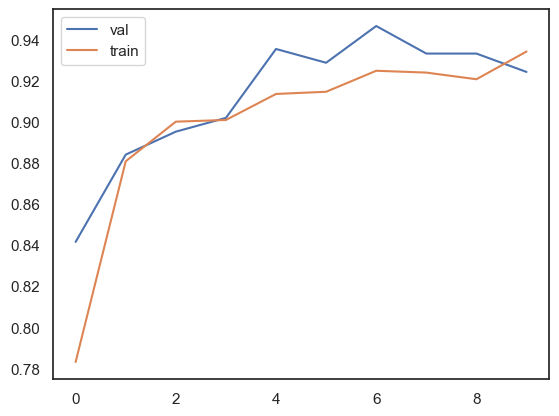

In [29]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

In [30]:
# Evaluate the model on the test dataset
scores = model.evaluate(test_ds)
print("Test accuracy:", scores[1])

15/15 [==============================] - 36s 397ms/step - loss: 0.1775 - accuracy: 0.9312
Test accuracy: 0.9312499165534973
